## 06 Extras: Stacking & Blending Practice

Notebook contents were partially inspired by <a href="https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending/"> Alexander Diakonov Blog </a>*`

### Let's have a short recap

### Bagging:

* Why Decision Trees are good to be used for bagging?
* How to estimate feature importances using the contructed Random Forest?
* How out-of-bag error is calculated using the constructed Random Forest?

### Practice: use Blending to finish EDA practice on Titanic Kaggle dataset

In [1]:
# If you are using colab, uncomment this cell 

! wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day05_Trees_and_Ensembles/data/titanic_dataset/test.csv
! wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day05_Trees_and_Ensembles/data/titanic_dataset/train.csv
  
! mkdir data
! mkdir data/titanic_dataset

! mv -t data/titanic_dataset train.csv test.csv

--2020-02-24 12:03:22--  https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day05_Trees_and_Ensembles/data/titanic_dataset/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443...connected.
HTTP request sent, awaiting response...200 OK
Length: 28629 (28K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]  27,96K  --.-KB/s    in 0,01s   

2020-02-24 12:03:22 (1,93 MB/s) - ‘test.csv’ saved [28629/28629]

--2020-02-24 12:03:22--  https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day05_Trees_and_Ensembles/data/titanic_dataset/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request 

In [2]:
from IPython.display import Image

import warnings
warnings.simplefilter("ignore")

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib.colors import ListedColormap
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
data=pd.read_csv('data/titanic_dataset/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Repeat the Data Pre-processing step

Save the Initials for people's names in the dataset

In [4]:
# lets extract the Salutations
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.')

data['Initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
    inplace=True)
data.groupby('Initial')['Age'].mean() #lets check the average age by Initials

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

Fill NaNs in `Age` column.

In [5]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [6]:
data.Age.isnull().any() #So no null values left finally 

False

Fill NaNs for `Embarked` column.

In [7]:
data['Embarked'].fillna('S',inplace=True)

In [8]:
# Finally No NaN values
data.Embarked.isnull().any()

False

#### Repeat the Feature Engineering step

Convert age values to age bands

In [9]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


Add `FamilySize` and `Alone` features.

In [10]:
# family size
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']
# aloneb
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1

Add `FareCat` for fare categories, based on fare distribution quantiles

In [11]:
data['Fare_Range'] = pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [12]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

Covnert string columns into numeric values

In [13]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

Drop unnecessary columns

In [14]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)

In [15]:
print(data.shape)

(891, 11)


#### Predictive Modelling

In [16]:
train,test=train_test_split(data, test_size=0.2, random_state=42, stratify=data['Survived'])

train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]

test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]

X=data[data.columns[1:]]
Y=data['Survived']

Let's have a logistic regression baseline

In [17]:
baseline_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
baseline_model.fit(train_X, train_Y)
prediction_bl = baseline_model.predict(test_X)
print('The ROC-AUC of the Logistic Regression is',metrics.roc_auc_score(prediction_bl, test_Y))

The ROC-AUC of the Logistic Regression is 0.8080163043478261


In [18]:
train_X.head()

,Pclass,Sex,SibSp,Parch,Embarked,Initial,Age_band,Family_Size,Alone,Fare_cat
692,3,0,0,0,0,0,2,0,1,3
481,2,0,0,0,0,0,2,0,1,0
527,1,0,0,0,0,0,2,0,1,3
855,3,1,0,1,0,1,1,1,0,1
801,2,1,1,1,0,1,1,2,0,2


In [19]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression    #logistic regression
from sklearn.ensemble import RandomForestClassifier    #Random Forest
from sklearn.neighbors import KNeighborsClassifier     #KNN
from sklearn.tree import DecisionTreeClassifier        #Decision Tree
from sklearn.model_selection import train_test_split   #training and testing data split
from sklearn import metrics                            #accuracy measure

In [20]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import GridSearchCV # grid search

kfold = KFold(n_splits=3, random_state=22)

xyz = []
roc_values_cv, std = [], []
roc_values_test = []
classifiers=['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']
models=[
    LogisticRegression(C=1e2),
    KNeighborsClassifier(n_neighbors=9),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=30, max_depth=5),
]

for i in models:
    model = i
    cv_result = cross_val_score(model, train_X, train_Y, cv=kfold, scoring="roc_auc")
    cv_result = cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    roc_values_cv.append(cv_result)
    model.fit(train_X, train_Y)
    roc_auc_test = metrics.roc_auc_score(model.predict(test_X), test_Y)
    roc_values_test.append(roc_auc_test)
    
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std, 'Test': roc_values_test} ,index=classifiers)       
new_models_dataframe2

,CV Mean,Std,Test
Logistic Regression,0.860278,0.014547,0.797353
KNN,0.853967,0.004611,0.757765
Decision Tree,0.855644,0.009093,0.833716
Random Forest,0.871355,0.007596,0.822117


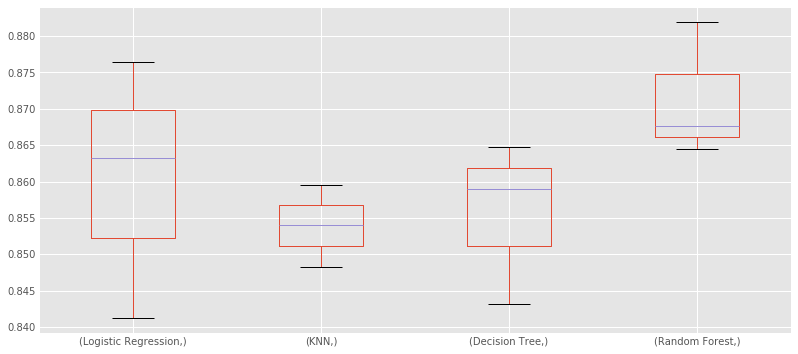

In [21]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(roc_values_cv,index=[classifiers])
box.T.boxplot()

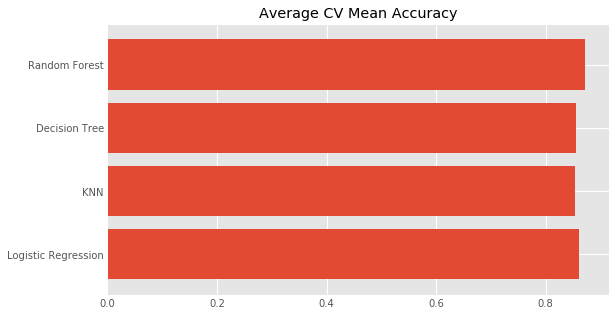

In [22]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

### Stacking and Blending Practice

Dataset is split into N parts (folds), then the base algorithms are iteratively fit to N-1 folds and generate predictions for the N-th fold. Those predictions are then treated as the new features for the given N-th fold. To generate such metafeatures for the testing set, base algorithms are fitted to the full training dataset instead.

<img src='https://github.com/neychev/harbour_ml2020/blob/master/day06_More_Ensembles/pics/stacking-eng.png?raw=1'>

Simple way of stacking - blending:
1. Split training set into two disjoint subsets
2. Train several base models using the first subset of the data
3. Generate predictions for the second subset using the trained base models, and vice versa
4. Using the predictions from 3. as features and the ground truth targets, train a classifier using such metafeatures (secod-level classifier)

<img src='https://github.com/neychev/harbour_ml2020/blob/master/day06_More_Ensembles/pics/blending-eng.png?raw=1'>

In [23]:
# for repeatability
SEED = 10

# number of folds for out-of-fold predictions
NFOLDS = 3
kf = KFold(n_splits=NFOLDS, random_state=SEED)

train_X, train_Y = np.array(train_X), np.array(train_Y)
test_X, test_Y = np.array(test_X), np.array(test_Y)

In [24]:
def get_oof(clf, x_train, y_train, x_test):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index, :]
        y_tr = y_train[train_index]
        x_te = x_train[test_index, :]

        clf.fit(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict_proba(x_te)[:, 1]
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:, 1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [25]:
model_lr = LogisticRegression(random_state=SEED)
model_knn = KNeighborsClassifier(n_neighbors=9)
model_dt = DecisionTreeClassifier(max_depth=5)
model_rf = RandomForestClassifier(n_estimators=100, random_state=SEED, max_depth=5)

In [26]:
# Create our OOF train and test predictions. These base results will be used as new features
lr_oof_train, lr_oof_test = get_oof(model_lr, train_X, train_Y, test_X) # Logistic Regression
knn_oof_train, knn_oof_test = get_oof(model_knn, train_X, train_Y, test_X) # KNN
dt_oof_train, dt_oof_test = get_oof(model_dt, train_X, train_Y, test_X) # XGBoost
rf_oof_train, rf_oof_test = get_oof(model_rf, train_X, train_Y, test_X) # Random Forest
print("Training is complete")

Training is complete


In [27]:
base_predictions_train = pd.DataFrame(
    {
        'LogReg': lr_oof_train.ravel(),
        'kNN': knn_oof_train.ravel(),
        'DecisionTree': dt_oof_train.ravel(),
        'RandomForest': rf_oof_train.ravel(),
        'GT': np.array(train_Y).ravel()
    }
)
base_predictions_train.head()

,LogReg,kNN,DecisionTree,RandomForest,GT
0,0.063423,0.111111,0.038462,0.155220,1
1,0.147086,0.000000,0.000000,0.080891,0
2,0.381086,0.222222,0.000000,0.254778,0
3,0.586858,0.444444,0.375000,0.610482,1
4,0.741351,0.666667,0.857143,0.797369,1


In [28]:
x_train = np.concatenate((lr_oof_train, knn_oof_train, dt_oof_train, rf_oof_train), axis=1)
x_test = np.concatenate((lr_oof_test, knn_oof_test, dt_oof_test, rf_oof_test), axis=1)

In [30]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()

# Create the parameter grid
gbm_param_grid = {
    'n_estimators': range(5, 50, 5),
    'max_depth': [2, 5, 10, -1],
    'learning_rate': [.4, .5, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

# Perform grid search
xgb_gs = GridSearchCV(
    estimator=xgb_model, 
    param_grid=gbm_param_grid,
    scoring="roc_auc",
    verbose=1,
    cv=3,
    n_jobs=-2
)

# Fit grid search to the data
xgb_gs.fit(x_train, train_Y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_gs.best_params_)
print("Best ROC-AUC found: ", xgb_gs.best_score_)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done 103 tasks      | elapsed:    6.1s
Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 10}
Best ROC-AUC found:  0.8733183072014494
[Parallel(n_jobs=-2)]: Done 1620 out of 1620 | elapsed:   13.8s finished


In [31]:
xgb_best = XGBClassifier(**xgb_gs.best_params_)
xgb_best.fit(x_train, train_Y)

print("Test ROC-AUC: ", metrics.roc_auc_score(xgb_best.predict(x_test), test_Y))

Test ROC-AUC:  0.8042247386759582


### Notes: